####  학습 데이터 생성 

- 먼저 [keggle](https://www.kaggle.com/c/dogs-vs-cats)에서 학습셋을 다운 받아 로컬에 압축을 풀어준다. 
- im2rec로 이미지 파일을 하나의 record io(`*.rec`)파일로 변환한다. 
- rec파일을 ImageRecordIter 객체로 만들어 학습셋, 테스트셋 준비를 완료한다. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.image import color_normalize
import mxnet.autograd as autograd
from mxnet.gluon.model_zoo import vision as models

In [2]:
#더미 파일 리스트를 구축한다. , im2rec.py는 https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py 
%run im2rec.py --list list catsdogs_full train

In [3]:
#아래 보는것과 같이 텝으로 구분되어서 파일 인덱스, 레이블(클래스), 사진파일명 정보가 구성된다. 
!head catsdogs_full.lst

3197	0.000000	cat.1625.jpg
15084	0.000000	dog.12322.jpg
1479	0.000000	cat.11328.jpg
5262	0.000000	cat.3484.jpg
20714	0.000000	dog.6140.jpg
9960	0.000000	cat.7712.jpg
945	0.000000	cat.10848.jpg
15585	0.000000	dog.1524.jpg
12376	0.000000	cat.9888.jpg
4367	0.000000	cat.2679.jpg


In [6]:
#pandas 테이블로 파일을 읽어들여 레이블을 마킹하고 랜덤 셔플한 뒤 학습과 테스트셋으로 만든다. 
catdoglist = pd.read_csv('catsdogs_full.lst',sep='\t', names=['idx', 'class', 'fn'])

catdoglist['class'] = [1  if i else 0 for i in catdoglist['fn'].str.contains('dog')]

catdoglist = shuffle(catdoglist)

train = catdoglist.iloc[:6500, ]

train.shape

test = catdoglist.iloc[6500:, ]

train.to_csv('catsdogs_train.lst',doublequote=False,sep='\t', header=False, index=False)
test.to_csv('catsdogs_test.lst',doublequote=False,sep='\t', header=False, index=False)

In [165]:
#실제 Image RecordIO dataset을 만든다. 
!python im2rec.py --num-thread 10 catsdogs_t train

/home/gogamza/python_3.6/lib/python3.6/distutils/__init__.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Creating .rec file from /home/gogamza/work/gluons/catsdogs_train.lst in /home/gogamza/work/gluons
time: 0.03124403953552246  count: 0
time: 1.179645299911499  count: 1000
time: 0.976043701171875  count: 2000
time: 1.1002657413482666  count: 3000
time: 1.051544189453125  count: 4000
time: 1.0289239883422852  count: 5000
time: 0.5287754535675049  count: 6000
Creating .rec file from /home/gogamza/work/gluons/catsdogs_test.lst in /home/gogamza/work/gluons
time: 0.18526077270507812  count: 0
time: 0.9183506965637207  count: 1000
time: 0.8911347389221191  count: 2000
time: 1.0432755947113037  count: 3000
time: 0.8570001125335693  count: 4000
time: 1.0042638778686523  count: 5000
time: 0.9739773273468018  count: 6000
time: 0.8833253383636475  count: 7000
time: 0.9417126178741455  count: 8000
ti

#### ImageRecordIter data augmentation 예제 

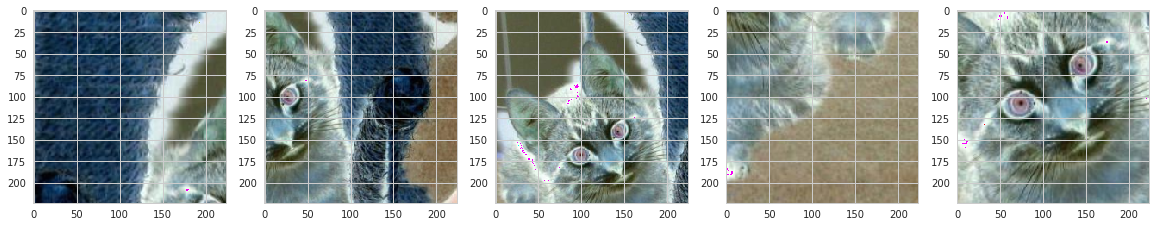

In [77]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

view_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=False,
                                   batch_size=1,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)

images = []
for j in range(5):
    for i, batch in enumerate(view_iter):
        images.append(batch.data[0].asnumpy().squeeze())
        view_iter.reset()
        break
        
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, image in enumerate(images):
    ax[i].imshow(image.swapaxes(0,1).swapaxes(1,2))

#### 학습/테스트 이터레이터 생성 

In [6]:
#생성한 rec 파일로 이터레이터를 생성한다. 
#Tensorflow와 케라스에서와는 다르게 채널이 먼저 나온다.
#이미지 학습을 하는데 ImageRecordIter는 거의 필수라고 생각하는데, 이는 다양한 data augmentation의 옵션을 제공하기 때문이다.
batch_size = 100  # GPU메모리 크기에 따라 정해준다. 
valid_batch_size = 60 #validation은 적어도 큰 문제가 없다. 
train_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec="catsdogs_test.rec",
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=valid_batch_size)

#### 모형 생성 

In [7]:
#학습은 GPU에서 
ctx = mx.gpu(0)

In [29]:
class cats_and_dogs_base(gluon.Block):
    def __init__(self, num_class, num_fc, **kwargs):
        super(cats_and_dogs_base, self).__init__(**kwargs)
        
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=32, kernel_size=3, activation='relu')
            self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
            self.conv2 = nn.Conv2D(channels=32, kernel_size=3, activation='relu')
            self.pool2 = nn.MaxPool2D(pool_size=2, strides=2)
            self.conv3 = nn.Conv2D(channels=64, kernel_size=3, activation='relu')
            self.pool3 = nn.MaxPool2D(pool_size=2, strides=2)
            # The Flatten layer collapses all axis, except the first one, into one axis.
            self.flatten = nn.Flatten()
            self.bnorm = nn.BatchNorm()
            self.dense = nn.Dense(num_fc, activation="relu")
            self.pred  = nn.Dense(num_class)
    
    def forward(self, inputs):
        #print("input shape : {}".format(inputs.shape))
        conv_1 = self.conv1(inputs)
        #print("conv1 shape : {}".format(conv_1.shape))
        pool_1 = self.pool1(conv_1)
        #print("pool1 shape : {}".format(pool_1.shape))
        conv_2 = self.conv2(pool_1)
        #print("conv2 shape : {}".format(conv_2.shape))
        pool_2 = self.pool2(conv_2)
        #print("pool2 shape : {}".format(pool_2.shape))
        conv_3 = self.conv3(pool_2)
        #print("conv3 shape : {}".format(conv_3.shape))
        pool_3 = self.pool3(conv_3)
        #print("pool3 shape : {}".format(pool_3.shape))
        flatted = self.bnorm(self.flatten(pool_3))
        #print("flatten shape {}: ".format(flatted.shape))
        densed = self.dense(flatted)
        #print("dense shape : {}".format(densed.shape))
        preded =  self.pred(densed)
        #print("pred shape : {}".format(preded.shape))
        return preded
        
        
        

In [30]:
model = cats_and_dogs_base(num_class=2, num_fc=512)

In [31]:
print(model)

cats_and_dogs_base(
  (conv1): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv3): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (flatten): Flatten
  (bnorm): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (dense): Dense(None -> 512, Activation(relu))
  (pred): Dense(None -> 2, linear)
)


#### Parameter initialization

In [32]:
model.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

#### Print Shape 

In [18]:
test_input = mx.nd.random_normal(0,1,(10, 3, 224, 224), ctx=ctx)

In [19]:
model(test_input)

input shape : (10, 3, 224, 224)
conv1 shape : (10, 32, 222, 222)
pool1 shape : (10, 32, 111, 111)
conv2 shape : (10, 32, 109, 109)
pool2 shape : (10, 32, 54, 54)
conv3 shape : (10, 64, 109, 109)
pool3 shape : (10, 64, 54, 54)
flatten shape (10, 186624): 
dense shape : (10, 512)
pred shape : (10, 2)



[[ 0.13404876 -0.02019071]
 [ 0.1083471   0.20212299]
 [ 0.1841412   0.12923685]
 [ 0.17872365  0.16308552]
 [ 0.28817564  0.19382435]
 [ 0.09513287  0.11958443]
 [ 0.19659781  0.23043178]
 [ 0.11613256  0.17632614]
 [ 0.10163498  0.13231185]
 [ 0.17074618  0.1142377 ]]
<NDArray 10x2 @gpu(0)>

#### Softmax cross-entropy Loss

In [33]:
loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

#### Optimizer

In [34]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': .001})

#### Write evaluation loop to calculate accuracy

In [35]:
def evaluate(net, data_iter, ctx):
    data_iter.reset()
    acc = mx.metric.Accuracy()
    for batch in data_iter:
        mx.nd.waitall()
        #reference 
        #https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        
        data = data.as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        mx.ndarray.waitall()
    return acc.get()[1]


In [36]:
import mxnet.autograd as autograd
from mxnet import gluon
import logging
import os
import time
import numpy as np
logging.basicConfig(level=logging.INFO)

def train(net,trainer,loss, train_iter, val_iter, epochs, ctx):

    val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation accuracy : {}'.format(val_accs))
    tr_loss = []
    val_accs = []
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        loss_seq = []
        for i, batch in enumerate(train_iter):
            #속도를 좀 감소시키더라도 GPU 메모리에 대한 관리를 더 한다.  
            mx.nd.waitall()
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = data.as_in_context(ctx)
            label = mx.nd.one_hot(batch.label[0].as_in_context(ctx),2)
            with autograd.record():
                z = net(data)
                L = loss(z, label)
                L.backward()
            trainer.step(data.shape[0])
            btic = time.time()
            curr_loss = mx.nd.mean(L).asscalar()
            loss_seq.append(curr_loss)
            mx.ndarray.waitall()
        logging.info('[Epoch {}] training loss : {}'.format(epoch, np.mean(loss_seq)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_acc = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation accuracy : %s'%(epoch, val_acc))
        val_accs.append(val_acc)
        tr_loss.append(np.mean(loss_seq))
    return(val_accs, tr_loss)

In [37]:
accs, losses = train(model,trainer, loss, train_iter, val_iter,50, ctx)

INFO:root:[Initial] validation accuracy : 0.49902597402597404
INFO:root:[Epoch 0] training loss : 5.342252254486084
INFO:root:[Epoch 0] time cost: 10.977739
INFO:root:[Epoch 0] validation accuracy : 0.526406926407
INFO:root:[Epoch 1] training loss : 0.9887674450874329
INFO:root:[Epoch 1] time cost: 10.900618
INFO:root:[Epoch 1] validation accuracy : 0.576051779935
INFO:root:[Epoch 2] training loss : 0.6650195121765137
INFO:root:[Epoch 2] time cost: 10.818107
INFO:root:[Epoch 2] validation accuracy : 0.622294372294
INFO:root:[Epoch 3] training loss : 0.6514518857002258
INFO:root:[Epoch 3] time cost: 10.776780
INFO:root:[Epoch 3] validation accuracy : 0.642207792208
INFO:root:[Epoch 4] training loss : 0.6423160433769226
INFO:root:[Epoch 4] time cost: 10.776105
INFO:root:[Epoch 4] validation accuracy : 0.656742179072
INFO:root:[Epoch 5] training loss : 0.6242806315422058
INFO:root:[Epoch 5] time cost: 10.823839
INFO:root:[Epoch 5] validation accuracy : 0.663636363636
INFO:root:[Epoch 6] t

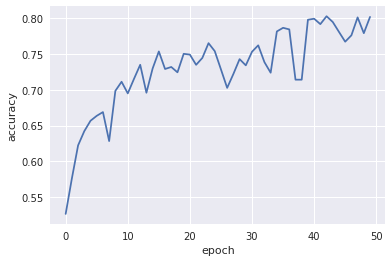

In [79]:
sns.set()
_, ax = plt.subplots(1)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.plot(accs)


80% 정확도가 가장 많이 올라갈 수 있는 퍼포먼스임. 더 상승 시키기 위해서는 좀더 튜닝이 필요하나 어렵다.

#### 분류 예제 

In [80]:
from skimage.color import rgba2rgb
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

#cpu에서 동작 시킨다.  
model.collect_params().reset_ctx(mx.cpu(0))

#reference : http://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html
def classify_dogcat(net, url): 
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    out = mx.nd.SoftmaxActivation(net(image))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['cat!', 'dog!']
    print(outstring[result])

Probabilities are: [ 0.15811776  0.84188223]
dog!


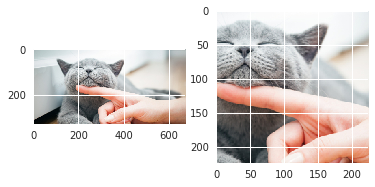

In [81]:
classify_dogcat(net=model, url="cats.jpg")

약 80%의 정확도로는 다소 어려운 문제였을 수 있으나, 체감 성능이 떨어지는건 어쩔 수 없음

Probabilities are: [ 0.05139632  0.94860375]
dog!


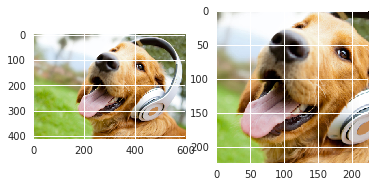

In [82]:
classify_dogcat(net=model, url="Cute-dog-listening-to-music-1_1.jpg")

#### 모형 저장/로딩 

In [83]:
model.save_params("cats_and_dogs_model_base.mdl")

In [84]:
new_model = cats_and_dogs_base(num_class=2, num_fc=512)

In [85]:
new_model.load_params('cats_and_dogs_model_base.mdl', ctx=mx.cpu(0))

Probabilities are: [ 0.05139632  0.94860375]
dog!


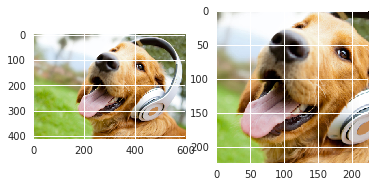

In [86]:
classify_dogcat(net=new_model, url="Cute-dog-listening-to-music-1_1.jpg")